lddt.shape:  torch.Size([245, 245])


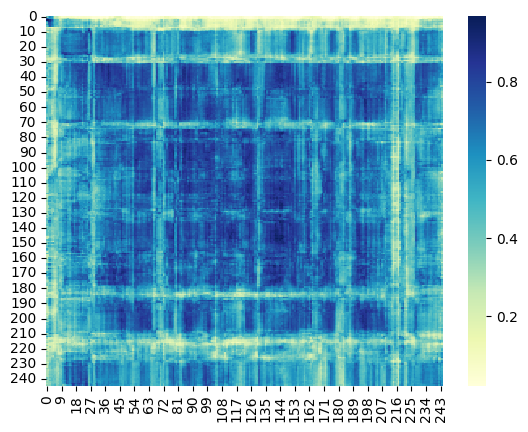

In [7]:
import torch
eps = 1e-7

import sys
sys.path.append("/home/rotation3/complex-coor-pred/")

def cal_lddt(predcadist,truecadist):
    ### predcadist: (N,L,L,L) 由xyzLLL3计算   pred
    ### truecadist: (N,L,L)   label
    ### lddt: (N,L,L)
    
    '''
    
    比较邻居个数
    
    jupyter notebook: /export/disk4/xyg/mixnet/analysis.ipynb

    对于一个残基，考虑序号间隔至少为s的(non local)，并且欧式距离小于15(空间足够接近，存在相互作用)所有残基。
    然后遍历所有残基
    然后计算平均值,如果不取平均值，则可以得到每个残基的lDDT,即一组数据,长度与序列长度同，alphafold2可预测此值
    lDDT分数取值范围：

    D: true distance
    d: predicted distance

    s: minimum sequence separation. lDDT original paper: default s=0
    t: threshold [0.5,1,2,4] the same ones used to compute the GDT-HA score
    Dmax: inclusion radius,far definition,according to lDDT paper

    Referenece
    0. AlphaFold1 SI
    1. lDDT original paper: doi:10.1093/bioinformatics/btt473
    
    '''
    N,L,L,L=predcadist.shape
    truecadist=torch.tile(truecadist[:,None,:,:],(1,L,1,1))
    
    Dmax=15.0
    maskfar=torch.as_tensor(truecadist<=Dmax,dtype=torch.float32) # (N,L,L,L)
    
    s=0  #  lDDT original paper: default s=0
    a=torch.arange(L).reshape([1,L]).to(maskfar.device)
    maskLocal=torch.as_tensor(torch.abs(a-a.T)>=s,dtype=torch.float32) # (L,L)
    maskLocal=torch.tile(maskLocal[None,None,:,:],(N,L,1,1))
    fenmu=maskLocal*maskfar

    Ratio=0
    t=[0.5,1,2,4] # the same ones used to compute the GDT-HA score
    for t0 in t:
        preserved=torch.as_tensor(torch.abs(truecadist-predcadist)<t0,dtype=torch.float32)
        fenzi=maskLocal*maskfar*preserved
        Ratio+=torch.sum(fenzi,dim=3)/(torch.sum(fenmu,dim=3)+eps)
    lddt=Ratio/4.0  # (N,L,L)  range (0,1]
    return lddt


if __name__ == "__main__":
    from utils.demo_of_model_and_eval import demo_pred_label
    net_pt_name = "/home/rotation3/complex-coor-pred/model/checkpoint/CoorNet_VII/epoch34.pt"
    pred_ls, label_ls = demo_pred_label(2, net_pt_name, shuffle=True) 

    lddt_ls = []
    for i in range(len(pred_ls)):
        pred = pred_ls[i]
        label = label_ls[i]

        pred = pred.unsqueeze(-2) - pred.unsqueeze(-3)

        pred = ((pred**2).sum(dim=-1) + eps) ** 0.5
        label = ((label**2).sum(dim=-1) + eps) ** 0.5

        lddt = cal_lddt(pred, label)
        lddt = lddt.squeeze()
        print("lddt.shape: ",lddt.shape)
        
        # Draw
        import seaborn as sns
        sns.heatmap(lddt.cpu(), cmap="YlGnBu")
        break



(95, 95)
(95, 95)
0.07211428


<Axes: >

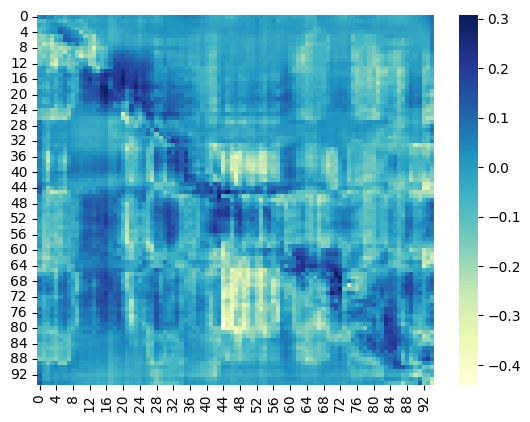

In [25]:
import torch
from torch.utils.data import DataLoader
from main import train_ds, test_ds
from config import device, NUM_BLOCKS
from utils.cal_lddt import cal_lddt

import sys
sys.path.append("/home/rotation3/complex-coor-pred/")



project_name = "Full_train"
plddt_epoch = 11
net_pt_name = "/home/rotation3/complex-coor-pred/model/checkpoint/CoorNet_VII/epoch34.pt"
eps = 1e-7
local_step = 0
global_step = 0
total_loss = 0
avg_loss = 0

from utils.pLDDT import pLDDT
get_pLDDT = torch.load("/home/rotation3/complex-coor-pred/utils/plddt_checkpoints/Full_train/epoch7_mark.pt")
get_pLDDT.eval()
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=True)
net_pt = torch.load(net_pt_name, map_location=device)
for param in net_pt.parameters():
    param.requires_grad = False

for data in test_dataloader:
    local_step += 1
    global_step += 1
    embed, atten, coor_label, L = data
    embed = embed.to(device)
    atten = atten.to(device)
    coor_label = coor_label.to(device)
    L = L.to(device)
    pred_coor_ls, pred_x2d = net_pt(embed, atten)
    pred = pred_coor_ls[NUM_BLOCKS-1]   # 取出最后一个Block预测出的coor

    predcadist = pred.unsqueeze(-2) - pred.unsqueeze(-3)   
    predcadist = ((predcadist**2).sum(dim=-1) + eps) ** 0.5   # predcadist  (N,L,L,L)
    label = ((coor_label**2).sum(dim=-1) + eps) ** 0.5
    lddt = cal_lddt(predcadist,label)
    plddt = get_pLDDT(pred, pred_x2d)
    loss = (((plddt - lddt)**2).sum() + eps) ** 0.5
    break

lddt = lddt.squeeze().detach().cpu().numpy()
plddt = plddt.squeeze().detach().cpu().numpy()

print(lddt.shape)
print(plddt.shape)
diff = plddt - lddt
print(abs(diff).mean())

import seaborn as sns
sns.heatmap(diff, cmap="YlGnBu")
